# Linking data on the web

In this notebook you'll experience how to consume structured data available on Wikidata to extend and enrich data managed within Nexus.


## Prerequisites

This notebook assumes you've created a project within the AWS deployment of Blue Brain Nexus. If not follow the Blue Brain Nexus [Quick Start tutorial](https://bluebrain.github.io/nexus/docs/tutorial/getting-started/quick-start/index.html).


## Overview

You'll work through the following steps:

1. Install and configure the Blue Brain Nexus python sdk
2. Create a sparql wrapper around your project's SparqlView
3. Create a sparql wrapper around the Wikidata Sparql Service
4. Query more metadata from the Wikidata Sparql Service for movies stored in Nexus using their tmdbId
5. Save the extended movies metadata back to Nexus and perform new queries

## Step 1: Install and configure the Blue Brain Nexus python sdk

In [3]:
!pip install git+https://github.com/BlueBrain/nexus-cli

  Cloning https://github.com/BlueBrain/nexus-cli to /tmp/pip-req-build-l7u3f1zc
  Running setup.py bdist_wheel for nexus-cli ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-_ry2whog/wheels/35/4d/e7/3f9a4e18d5aeff30a45ea0679cdddcfc2070db173397b7b741
Successfully built nexus-cli


In [0]:
import nexussdk as nexus


nexus_deployment = "https://nexus-sandbox.io/v1"

token = "eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICItSm9GOUNPdnZ0N1VoeWhKTUMtWWxURjZwaVJsWmdRS1JRa3M1c1BNS3h3In0.eyJqdGkiOiIwNzI2NTc5ZS1mOTM3LTRjYTgtOTdlZi0xOWE4MjMzOTU0NGMiLCJleHAiOjE1NDkxODM1NzEsIm5iZiI6MCwiaWF0IjoxNTQ4NTc4NzcxLCJpc3MiOiJodHRwczovL25leHVzLXNhbmRib3guaW8vYXV0aC9yZWFsbXMvZ2l0aHViIiwiYXVkIjoiYWNjb3VudCIsInN1YiI6ImY0ZmY1ZWMyLTJjOGQtNDM1YS1hZWFmLWUyMDU3MTJmMDYzYSIsInR5cCI6IkJlYXJlciIsImF6cCI6Im5leHVzLXdlYiIsIm5vbmNlIjoiMTIzNDU2IiwiYXV0aF90aW1lIjoxNTQ4NTc4NzcxLCJzZXNzaW9uX3N0YXRlIjoiY2M5NGVkMWItOWM1OC00NmE5LWI0OWEtMjhlYzgzOGM4YTI2IiwiYWNyIjoiMSIsInJlYWxtX2FjY2VzcyI6eyJyb2xlcyI6WyJvZmZsaW5lX2FjY2VzcyIsInVtYV9hdXRob3JpemF0aW9uIl19LCJyZXNvdXJjZV9hY2Nlc3MiOnsiYWNjb3VudCI6eyJyb2xlcyI6WyJtYW5hZ2UtYWNjb3VudCIsIm1hbmFnZS1hY2NvdW50LWxpbmtzIiwidmlldy1wcm9maWxlIl19fSwic2NvcGUiOiJvcGVuaWQgcHJvZmlsZSBlbWFpbCIsInN1YiI6ImFnYXJjaSIsImVtYWlsX3ZlcmlmaWVkIjpmYWxzZSwibmFtZSI6IkFtYW5kYSBHYXJjaSIsInByZWZlcnJlZF91c2VybmFtZSI6ImFnYXJjaSIsImdpdmVuX25hbWUiOiJBbWFuZGEiLCJmYW1pbHlfbmFtZSI6IkdhcmNpIiwiZW1haWwiOiJyaWdvdmlydXRhQGdtYWlsLmNvbSJ9.g1V9CP3s9XXNVuAbia1L1qX8jLI4qSimTSMFOVuCX6xrcvUyZ-bPFuPQeLVkkjGQuS973wd538eS9B9J2JgZxsK3Dkzv8yWMD7dOohLnEz-DWqAC8d-Pei_bVlf6PReiTru2ggt6VoeaoO9qXDVYEUKL0T12YsEFsyM687FIUDlwz5cVqo-aVA1rP-HUCZxTzf2peRW476dw6iRSJsDkhx3HhZNsHzk_U9GXCW916-Wc9KyshNQvYcJF5nv4o-U6qgnUqWz72aw13b2W7xD6_WLvl_2FgY35jVC9kOzIdGaI-0oDLmeW5LvgYJYD9skLuup3riY1Dbsqt97sPd3mtA"
nexus.config.set_environment(nexus_deployment)
nexus.config.set_token(token)

org ="amld"
project ="onlymovies"

headers = {}



## Step 2: Create a sparql wrapper around your project's SparqlView

Every project in Blue Brain Nexus comes with a SparqlView enabling to navigate the data as a graph and to query it using the [W3C SPARQL Language](https://www.w3.org/TR/sparql11-query/). 
The address of such SparqlView is https://nexus-sandbox.io/v1/views/tutorialnexus/\$PROJECTLABEL/graph/sparql for a project withe label \$PROJECTLABEL. The address of a SparqlView is also called a sparql endpoint.

In [5]:
!pip install git+https://github.com/RDFLib/sparqlwrapper

  Cloning https://github.com/RDFLib/sparqlwrapper to /tmp/pip-req-build-kz7cnj9k
  Running setup.py bdist_wheel for SPARQLWrapper ... - \ | / done
  Stored in directory: /tmp/pip-ephem-wheel-cache-1jgxeyzm/wheels/94/87/ff/bd3f8bccb74168f42b5ba997f9105e18a9cc2699ad9a5525a6
Successfully built SPARQLWrapper


In [0]:
# Utility functions to create sparql wrapper around a sparql endpoint

from SPARQLWrapper import SPARQLWrapper, JSON, POST, GET, POSTDIRECTLY, CSV
import requests



def create_sparql_client(sparql_endpoint, http_query_method=POST, result_format= JSON, token=None):
    sparql_client = SPARQLWrapper(sparql_endpoint)
    #sparql_client.addCustomHttpHeader("Content-Type", "application/sparql-query")
    if token:
        sparql_client.addCustomHttpHeader("Authorization","Bearer {}".format(token))
    sparql_client.setMethod(http_query_method)
    sparql_client.setReturnFormat(result_format)
    if http_query_method == POST:
        sparql_client.setRequestMethod(POSTDIRECTLY)
    
    return sparql_client





In [0]:
# Utility functions
import pandas as pd

pd.set_option('display.max_colwidth', -1)

# Convert SPARQL results into a Pandas data frame
def sparql2dataframe(json_sparql_results):
    cols = json_sparql_results['head']['vars']
    out = []
    for row in json_sparql_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)
    return pd.DataFrame(out, columns=cols)

# Send a query using a sparql wrapper 
def query_sparql(query, sparql_client):
    sparql_client.setQuery(query)
    #request = sparql_client._createRequest()
    #print(sparql_client.endpoint)
    #print(sparql_client.queryString)
    #print(request.__dict__)

    result_object = sparql_client.query()
    if sparql_client.returnFormat == JSON:
        return result_object._convertJSON()
    return result_object.convert()



Let create a sparql wrapper around the project sparql view

In [0]:

sparqlview_endpoint = nexus_deployment+"/views/"+org+"/"+project+"/graph/sparql"
sparqlview_wrapper = create_sparql_client(sparql_endpoint=sparqlview_endpoint, token=token,http_query_method= POST, result_format=JSON)


Let test that the SparqlView wrapper works by running a simple Sparql query to get 5 movies along with their titles.

In [15]:
five_movie_query = """
PREFIX vocab: <https://nexus-sandbox.io/v1/vocabs/amld/onlymovies/>
PREFIX nxv: <https://bluebrain.github.io/nexus/vocabulary/>
Select ?movie_nexus_Id ?movieId ?title ?genres ?imdbId ?tmdbId ?revision
 WHERE  {
   
    ?movie_nexus_Id a vocab:Movie.
    ?movie_nexus_Id nxv:rev ?revision.
    ?movie_nexus_Id vocab:movieId ?movieId.
    ?movie_nexus_Id vocab:title ?title.
    ?movie_nexus_Id vocab:imdbId ?imdbId.
    ?movie_nexus_Id vocab:genres ?genres.
    OPTIONAL {
        ?movie_nexus_Id vocab:tmdbId ?tmdbId.
    }
} LIMIT 5
"""

nexus_results = query_sparql(five_movie_query,sparqlview_wrapper)


nexus_df =sparql2dataframe(nexus_results)
nexus_df.head()

,movie_nexus_Id,movieId,title,genres,imdbId,tmdbId,revision
0,https://nexus-sandbox.io/v1/resources/amld/onlymovies/_/Movie_2376,2376,"View to a Kill, A (1985)",Action|Adventure|Thriller,90264,707,2
1,https://nexus-sandbox.io/v1/resources/amld/onlymovies/_/Movie_2694,2694,Big Daddy (1999),Comedy,142342,9032,2
2,https://nexus-sandbox.io/v1/resources/amld/onlymovies/_/Movie_2931,2931,Time of the Gypsies (Dom za vesanje) (1989),Comedy|Crime|Drama|Fantasy,97223,20123,2
3,https://nexus-sandbox.io/v1/resources/amld/onlymovies/_/Movie_2138,2138,Watership Down (1978),Adventure|Animation|Children|Drama|Fantasy,78480,11837,2
4,https://nexus-sandbox.io/v1/resources/amld/onlymovies/_/Movie_1050,1050,Looking for Richard (1996),Documentary|Drama,116913,42314,2


## Step 3: Create a Sparql wrapper around the Wikidata Sparql Service

In [0]:
wikidata_sparql_endpoint = "https://query.wikidata.org/sparql"
wikidata_sparql_wrapper = create_sparql_client(sparql_endpoint=wikidata_sparql_endpoint,http_query_method= GET, result_format=JSON)


Let test that the wrapper works by running a query that fetch the logo url for a given movie tmdbId 862 (Toy Story).
You can play the following query in the Wikidata playground [Try It](https://query.wikidata.org/#SELECT%20%2a%0A%20%20%20%20WHERE%0A%20%20%20%20%7B%0A%20%20%20%20%20%20%20%20%3Fmovie%20wdt%3AP4947%20%22862%22.%0A%20%20%20%20%20%20%20%20OPTIONAL%7B%0A%20%20%20%20%20%20%20%20%3Fmovie%20wdt%3AP154%20%3Flogo.%0A%20%20%20%20%20%20%20%20%7D%0A%20%20%20%20%20%20%20%20OPTIONAL%7B%0A%20%20%20%20%20%20%20%20%3Fmovie%20wdt%3AP364%20%3Flang.%0A%20%20%20%20%20%20%20%20%7D%0A%20%20%20%20%20%20%20%20OPTIONAL%7B%0A%20%20%20%20%20%20%20%20%3Fmovie%20wdt%3AP577%20%3FreleaseDate.%0A%20%20%20%20%20%20%20%20%3Fmovie%20wdt%3AP291%20wdt%3AQ30.%0A%20%20%20%20%20%20%20%20%7D%0A%20%20%20%20%7D).

In [16]:
# wdt:P4947 is the wikidata property for tmdbId

movie_logo_query = """
SELECT *
WHERE
{
    ?movie wdt:P4947 "%s". #wdt:P4947 is the wikidata property for tmdbId
    OPTIONAL{
    ?movie wdt:P154 ?logo. #wdt:P154 is the wiki data property for logo image url
    }
}
""" % (862)
wiki_results = query_sparql(movie_logo_query,wikidata_sparql_wrapper)
wiki_df =sparql2dataframe(wiki_results)
wiki_df.head()



,movie,logo
0,http://www.wikidata.org/entity/Q171048,http://commons.wikimedia.org/wiki/Special:FilePath/Toy%20Story%20logo.svg


Let display the logo of the Toy Story movie. This part might take some time but you can skip it.

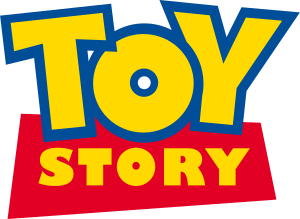

In [14]:
from IPython.display import SVG, display

movie_logo_url = wiki_df.at[0,'logo']
display(SVG(movie_logo_url))

## Step 4: Query more metadata from the Wikidata Sparql Service

For every movie with a tmdbId retrieved from the Nexus SparqlView, we will get:

* its cast members or voice actors first and last names
* its publication date in the United States of America if any

[Try it](https://query.wikidata.org/#SELECT%20%3FtmdbId%20%3Fmovie%20%3Flogo%20%3Fnativelanguage%20%3Fpublication_date%20%3Fcast%20%3FgivenName%20%3FfamilyName%0A%20%20%20%20WHERE%0A%20%20%20%20%7B%0A%20%20%20%20%20%20%20%20%3Fmovie%20wdt%3AP4947%20%3FtmdbId.%0A%20%20%20%20%20%20%20%20FILTER%20%28%3FtmdbId%20%3D%20%22862%22%29.%0A%20%20%20%20%20%20%20%20OPTIONAL%7B%0A%20%20%20%20%20%20%20%20%20%20%3Fmovie%20wdt%3AP154%20%3Flogo.%0A%20%20%20%20%20%20%20%20%7D%0A%20%20%20%20%20%20%20%20OPTIONAL%7B%0A%20%20%20%20%20%20%20%20%20%20%3Fmovie%20wdt%3AP725%7Cwdt%3AP161%20%3Fcast.%0A%20%20%20%20%20%20%20%20%20%20%3Fcast%20wdt%3AP735%2Fwdt%3AP1705%20%3FgivenName.%0A%20%20%20%20%20%20%20%20%20%20%3Fcast%20wdt%3AP734%2Fwdt%3AP1705%20%3FfamilyName.%0A%20%20%20%20%20%20%20%20%7D%0A%20%20%20%20%20%20%20%20OPTIONAL%7B%0A%20%20%20%20%20%20%20%20%3Fmovie%20wdt%3AP364%2Fwdt%3AP1705%20%3Fnativelanguage.%0A%20%20%20%20%20%20%20%20%7D%0A%20%20%20%20%20%20%20%0A%20%20%20%20%20%20OPTIONAL%20%7B%0A%20%20%20%20%20%3Fmovie%20p%3AP577%20%3Fpublication_date_node.%0A%20%20%20%20%20%3Fpublication_date_node%20ps%3AP577%20%3Fpublication_date.%20%23%20publication%20date%20statement%0A%20%20%20%20%20%3Fpublication_date_node%20pq%3AP291%20wd%3AQ30.%20%20%20%20%20%20%20%20%20%20%20%20%23%20qualifier%20on%20the%20release%20date%0A%20%20%7D%0A%20%20%20%20%7D) for the movie Toy Story.

In [17]:
from functools import reduce
import json


def panda_merge(df,df2, on):
    cols_to_use = df2.columns.difference(df.columns)
    dfNew = pd.merge(df, df2[cols_to_use], left_index=True, right_index=True, how='outer')
    return dfNew

def panda_concatenate(dfs):
    df = pd.concat(dfs)
    return df

wiki_dataframes = []
for index, row in nexus_df.iterrows():
    imdbdId = row['tmdbId']
    movie_logo_query = """
    SELECT ?tmdbId ?movie ?logo ?nativelanguage ?publication_date ?cast ?givenName ?familyName
    WHERE
    {
        ?movie wdt:P4947 ?tmdbId.
        FILTER (?tmdbId = "%s").
        OPTIONAL{
          ?movie wdt:P154 ?logo.
        }
        OPTIONAL{
          ?movie wdt:P725|wdt:P161 ?cast.
          ?cast wdt:P735/wdt:P1705 ?givenName.
          ?cast wdt:P734/wdt:P1705 ?familyName.
        }
        OPTIONAL{
        ?movie wdt:P364/wdt:P1705 ?nativelanguage.
        }
       
      OPTIONAL {
     ?movie p:P577 ?publication_date_node.
     ?publication_date_node ps:P577 ?publication_date. # publication date statement
     ?publication_date_node pq:P291 wd:Q30.            # qualifier on the release date
  }
    }
    """ % (row['tmdbId'])
    
    wiki_results = query_sparql(movie_logo_query,wikidata_sparql_wrapper)
    wiki_df =sparql2dataframe(wiki_results)
    display(wiki_df.head())
    wiki_dataframes.append(wiki_df)


#Let concatenate all dataframes from wikidata
result_wiki_dataframes = panda_concatenate(wiki_dataframes)
display(result_wiki_dataframes.head(100))


merge_wiki_dataframes = panda_merge(result_wiki_dataframes,nexus_df,"tmdbId")

display(merge_wiki_dataframes.head())

wiki_dataframes_tojson = (merge_wiki_dataframes.apply(lambda x: x.dropna(), 1).groupby(['tmdbId','movie','nativelanguage'], as_index=False)
                         .apply(lambda x: x[['cast','givenName','familyName']].to_dict('r'))
                         .reset_index()
                         .rename(columns={0:'casting'})
                         .to_json(orient='records'))





updated_movies_json = json.loads(wiki_dataframes_tojson)

print(json.dumps(updated_movies_json, indent=2, sort_keys=True))

,tmdbId,movie,logo,nativelanguage,publication_date,cast,givenName,familyName
0,707,http://www.wikidata.org/entity/Q332368,None,English,1985-05-24T00:00:00Z,http://www.wikidata.org/entity/Q61552,Walter,Gotell
1,707,http://www.wikidata.org/entity/Q332368,None,English,1985-05-24T00:00:00Z,http://www.wikidata.org/entity/Q463584,Fiona,Fullerton
2,707,http://www.wikidata.org/entity/Q332368,None,English,1985-05-24T00:00:00Z,http://www.wikidata.org/entity/Q3440161,Roland,Malet
3,707,http://www.wikidata.org/entity/Q332368,None,English,1985-05-24T00:00:00Z,http://www.wikidata.org/entity/Q185051,Christopher,Walken
4,707,http://www.wikidata.org/entity/Q332368,None,English,1985-05-24T00:00:00Z,http://www.wikidata.org/entity/Q450429,Grace,Jones


,tmdbId,movie,logo,nativelanguage,publication_date,cast,givenName,familyName
0,9032,http://www.wikidata.org/entity/Q509025,None,English,None,http://www.wikidata.org/entity/Q132952,Adam,Sandler
1,9032,http://www.wikidata.org/entity/Q509025,None,English,None,http://www.wikidata.org/entity/Q1706646,Joseph,Bologna
2,9032,http://www.wikidata.org/entity/Q509025,None,English,None,http://www.wikidata.org/entity/Q518868,Dennis,Dugan
3,9032,http://www.wikidata.org/entity/Q509025,None,English,None,http://www.wikidata.org/entity/Q211987,Jonathan,Leibowitz
4,9032,http://www.wikidata.org/entity/Q509025,None,English,None,http://www.wikidata.org/entity/Q2075598,Jonathan,Loughran


,tmdbId,movie,logo,nativelanguage,publication_date,cast,givenName,familyName
0,20123,http://www.wikidata.org/entity/Q615979,None,italiano,None,http://www.wikidata.org/entity/Q1250100,Bora,Тодоровић


,tmdbId,movie,logo,nativelanguage,publication_date,cast,givenName,familyName
0,11837,http://www.wikidata.org/entity/Q2165639,None,English,None,http://www.wikidata.org/entity/Q1340574,Harry,Andrews
1,11837,http://www.wikidata.org/entity/Q2165639,None,English,None,http://www.wikidata.org/entity/Q600632,Simon,Cadell
2,11837,http://www.wikidata.org/entity/Q2165639,None,English,None,http://www.wikidata.org/entity/Q200405,John,Hurt
3,11837,http://www.wikidata.org/entity/Q2165639,None,English,None,http://www.wikidata.org/entity/Q200405,Vincent,Hurt
4,11837,http://www.wikidata.org/entity/Q2165639,None,English,None,http://www.wikidata.org/entity/Q2734945,Richard David,Briers


,tmdbId,movie,logo,nativelanguage,publication_date,cast,givenName,familyName
0,42314,http://www.wikidata.org/entity/Q1493156,None,English,None,http://www.wikidata.org/entity/Q170572,Alexander,Baldwin
1,42314,http://www.wikidata.org/entity/Q1493156,None,English,None,http://www.wikidata.org/entity/Q101797,Laura,Ryder
2,42314,http://www.wikidata.org/entity/Q1493156,None,English,None,http://www.wikidata.org/entity/Q105817,Kevin,Kline
3,42314,http://www.wikidata.org/entity/Q1493156,None,English,None,http://www.wikidata.org/entity/Q586857,Kevin,Conway
4,42314,http://www.wikidata.org/entity/Q1493156,None,English,None,http://www.wikidata.org/entity/Q22667671,Leo,Colby


,tmdbId,movie,logo,nativelanguage,publication_date,cast,givenName,familyName
0,707,http://www.wikidata.org/entity/Q332368,None,English,1985-05-24T00:00:00Z,http://www.wikidata.org/entity/Q61552,Walter,Gotell
1,707,http://www.wikidata.org/entity/Q332368,None,English,1985-05-24T00:00:00Z,http://www.wikidata.org/entity/Q463584,Fiona,Fullerton
2,707,http://www.wikidata.org/entity/Q332368,None,English,1985-05-24T00:00:00Z,http://www.wikidata.org/entity/Q3440161,Roland,Malet
3,707,http://www.wikidata.org/entity/Q332368,None,English,1985-05-24T00:00:00Z,http://www.wikidata.org/entity/Q185051,Christopher,Walken
4,707,http://www.wikidata.org/entity/Q332368,None,English,1985-05-24T00:00:00Z,http://www.wikidata.org/entity/Q450429,Grace,Jones
5,707,http://www.wikidata.org/entity/Q332368,None,English,1985-05-24T00:00:00Z,http://www.wikidata.org/entity/Q232429,Maud,Adams
6,707,http://www.wikidata.org/entity/Q332368,None,English,1985-05-24T00:00:00Z,http://www.wikidata.org/entity/Q232356,Tanya,Roberts
7,707,http://www.wikidata.org/entity/Q332368,None,English,1985-05-24T00:00:00Z,http://www.wikidata.org/entity/Q232860,Lois,Maxwell
8,707,http://www.wikidata.org/entity/Q332368,None,English,1985-05-24T00:00:00Z,http://www.wikidata.org/entity/Q134333,Roger,Moore
9,707,http://www.wikidata.org/entity/Q332368,None,English,1985-05-24T00:00:00Z,http://www.wikidata.org/entity/Q460578,Michael,Wilson


,tmdbId,movie,logo,nativelanguage,publication_date,cast,givenName,familyName,genres,imdbId,movieId,movie_nexus_Id,revision,title
0,707,http://www.wikidata.org/entity/Q332368,None,English,1985-05-24T00:00:00Z,http://www.wikidata.org/entity/Q61552,Walter,Gotell,Action|Adventure|Thriller,90264,2376,https://nexus-sandbox.io/v1/resources/amld/onlymovies/_/Movie_2376,2,"View to a Kill, A (1985)"
0,9032,http://www.wikidata.org/entity/Q509025,None,English,None,http://www.wikidata.org/entity/Q132952,Adam,Sandler,Action|Adventure|Thriller,90264,2376,https://nexus-sandbox.io/v1/resources/amld/onlymovies/_/Movie_2376,2,"View to a Kill, A (1985)"
0,20123,http://www.wikidata.org/entity/Q615979,None,italiano,None,http://www.wikidata.org/entity/Q1250100,Bora,Тодоровић,Action|Adventure|Thriller,90264,2376,https://nexus-sandbox.io/v1/resources/amld/onlymovies/_/Movie_2376,2,"View to a Kill, A (1985)"
0,11837,http://www.wikidata.org/entity/Q2165639,None,English,None,http://www.wikidata.org/entity/Q1340574,Harry,Andrews,Action|Adventure|Thriller,90264,2376,https://nexus-sandbox.io/v1/resources/amld/onlymovies/_/Movie_2376,2,"View to a Kill, A (1985)"
0,42314,http://www.wikidata.org/entity/Q1493156,None,English,None,http://www.wikidata.org/entity/Q170572,Alexander,Baldwin,Action|Adventure|Thriller,90264,2376,https://nexus-sandbox.io/v1/resources/amld/onlymovies/_/Movie_2376,2,"View to a Kill, A (1985)"


[
  {
    "casting": [
      {
        "cast": "http://www.wikidata.org/entity/Q1340574",
        "familyName": "Andrews",
        "givenName": "Harry"
      },
      {
        "cast": "http://www.wikidata.org/entity/Q600632",
        "familyName": "Cadell",
        "givenName": "Simon"
      },
      {
        "cast": "http://www.wikidata.org/entity/Q200405",
        "familyName": "Hurt",
        "givenName": "John"
      },
      {
        "cast": "http://www.wikidata.org/entity/Q200405",
        "familyName": "Hurt",
        "givenName": "Vincent"
      },
      {
        "cast": "http://www.wikidata.org/entity/Q2734945",
        "familyName": "Briers",
        "givenName": "Richard David"
      }
    ],
    "movie": "http://www.wikidata.org/entity/Q2165639",
    "nativelanguage": "English",
    "tmdbId": "11837"
  },
  {
    "casting": [
      {
        "cast": "http://www.wikidata.org/entity/Q1250100",
        "familyName": "\u0422\u043e\u0434\u043e\u0440\u043e\u0432\u0438\u045b",

## Step 5: Save the extended movies metadata back to Nexus

In [18]:
display(nexus_df.head())
from urllib.parse import urlencode, quote_plus

def update_in_nexus(row):
    row["@type"]= "Movie"
    _id = nexus_df.loc[nexus_df['tmdbId'] == row['tmdbId'], 'movie_nexus_Id'].iloc[0]
    rev = nexus_df.loc[nexus_df['tmdbId'] == row['tmdbId'], 'revision'].iloc[0]
    row["title"] = nexus_df.loc[nexus_df['tmdbId'] == row['tmdbId'], 'title'].iloc[0]
    row["genres"] = nexus_df.loc[nexus_df['tmdbId'] == row['tmdbId'], 'genres'].iloc[0]
    row["movieId"] = nexus_df.loc[nexus_df['tmdbId'] == row['tmdbId'], 'movieId'].iloc[0]
    row["imdbId"] = nexus_df.loc[nexus_df['tmdbId'] == row['tmdbId'], 'imdbId'].iloc[0]
    
    url = nexus_deployment+"/resources/"+org+"/"+project+"/"+"_/"+quote_plus(_id)
    row["_self"] = url
    nexus.resources.update(resource=row, rev=rev)
    
for item in updated_movies_json:
    update_in_nexus(item)
    

,movie_nexus_Id,movieId,title,genres,imdbId,tmdbId,revision
0,https://nexus-sandbox.io/v1/resources/amld/onlymovies/_/Movie_2376,2376,"View to a Kill, A (1985)",Action|Adventure|Thriller,90264,707,2
1,https://nexus-sandbox.io/v1/resources/amld/onlymovies/_/Movie_2694,2694,Big Daddy (1999),Comedy,142342,9032,2
2,https://nexus-sandbox.io/v1/resources/amld/onlymovies/_/Movie_2931,2931,Time of the Gypsies (Dom za vesanje) (1989),Comedy|Crime|Drama|Fantasy,97223,20123,2
3,https://nexus-sandbox.io/v1/resources/amld/onlymovies/_/Movie_2138,2138,Watership Down (1978),Adventure|Animation|Children|Drama|Fantasy,78480,11837,2
4,https://nexus-sandbox.io/v1/resources/amld/onlymovies/_/Movie_1050,1050,Looking for Richard (1996),Documentary|Drama,116913,42314,2


The data can now be filtered with the new metadata


In [1]:
# Find movies within which James Broadbent acted

query = """
PREFIX vocab: <https://nexus-sandbox.io/v1/vocabs/amld/onlymovies/>
PREFIX nxv: <https://bluebrain.github.io/nexus/vocabulary/>
Select ?movieId ?title ?genres ?imdbId ?tmdbId
 WHERE  {
   
    ?movie_nexus_Id a vocab:Movie.
    ?movie_nexus_Id vocab:cating ?cast.
    ?cast vocab:familyname "Broadbent".
    ?cast vocab:familyname "James".
    ?movie_nexus_Id vocab:movieId ?movieId.
    ?movie_nexus_Id vocab:title ?title.
    ?movie_nexus_Id vocab:imdbId ?imdbId.
    ?movie_nexus_Id vocab:genres ?genres.
    OPTIONAL {
        ?movie_nexus_Id vocab:tmdbId ?tmdbId.
    }
} LIMIT 5
"""

nexus_results = query_sparql(query, sparqlview_wrapper)


nexus_df =sparql2dataframe(nexus_results)
nexus_df.head()

NameError: ignored